# Домашнее задание TTS.

В данном домашнем задании вам предстоит реализовать пайплайн модели, которая генерирует речь по заданному тексту.

<img src=https://download.pytorch.org/torchaudio/tutorial-assets/tacotron2_tts_pipeline.png width=640>

Пайплайн состоит из трех этапов:
1. Предобработка текста  
   Необходимо преобразовать входящий текст в набор символов или набор фонем
2. Генерирование спектрограммы  
   На данном этапе воспользуемся предобученным трансформером 
3. Преобразование спектрограммы в аудио

In [1]:
!wget "https://www.dropbox.com/scl/fi/wl3885jwnob9e9f79up1b/sample1.wav?rlkey=p1332lsf24gt1kwrlj528jtn1&st=wbggie3m&dl=1" -O sample1.wav -q

### Задание 1. Mel-Spectrogram

<img src=https://www.researchgate.net/publication/346243843/figure/fig1/AS:961807523000322@1606324191138/Short-time-Fourier-transform-STFT-overview.png width=640>

In [4]:
import torch
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import numpy as np
device = "mps" if torch.cuda.is_available() else "cpu"

In [5]:
wav_path = 'sample1.wav'
ipd.display(ipd.Audio(wav_path))

Length: 3.947392290249433 seconds at sample rate 22050


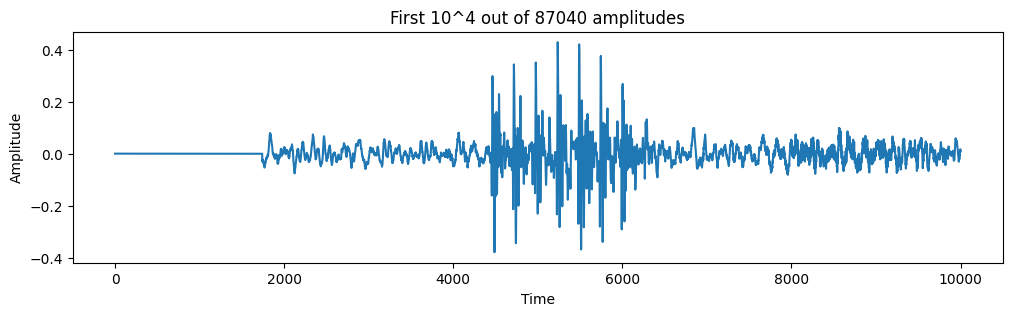

In [6]:
amplitudes, sample_rate = librosa.core.load(wav_path)

print("Length: {} seconds at sample rate {}".format(amplitudes.shape[0] / sample_rate, sample_rate))
plt.figure(figsize=[12, 3])
plt.title("First 10^4 out of {} amplitudes".format(len(amplitudes)))
plt.plot(amplitudes[:10000]);
plt.xlabel("Time")
plt.ylabel("Amplitude");

Типичный wav аудио файл содержит 22050 амплитуд в каждой секунде записи. Методами NLP очень тяжело обрабатывать последовательности такой длины, поэтому необходимо преобразовать данные в более удобный формат.

### Задание 1.1 (3 балла) Wav to Mel-Spectrogram

Для составления спектрограммы от амплитуд $y$ необходимо выполнить следующие шаги:  
1. Вычислить Оконное преобразование Фурье по пересекающимся окнам  
2. Построить спектрограмму: $S_{ij} = abs(STFT(y)_{ij}^2)$
3. Сконвертировать спектрограмму в мел-спектрограмму

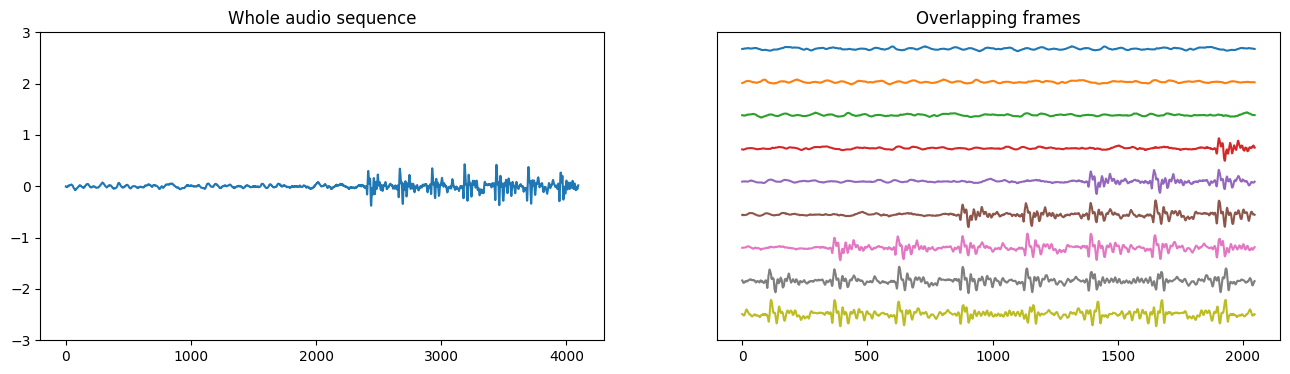

In [7]:
# Some helpers:
# 1. slice time-series into overlapping windows
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # output shape: [window_length, num_windows]

dummy_amps = amplitudes[2048: 6144]
dummy_frames = slice_into_frames(dummy_amps, 2048, 512)

plt.figure(figsize=[16, 4])
plt.subplot(121, title='Whole audio sequence', ylim=[-3, 3])
plt.plot(dummy_amps)

plt.subplot(122, title='Overlapping frames', yticks=[])
for i, frame in enumerate(dummy_frames.T):
    plt.plot(frame + 10 - i);

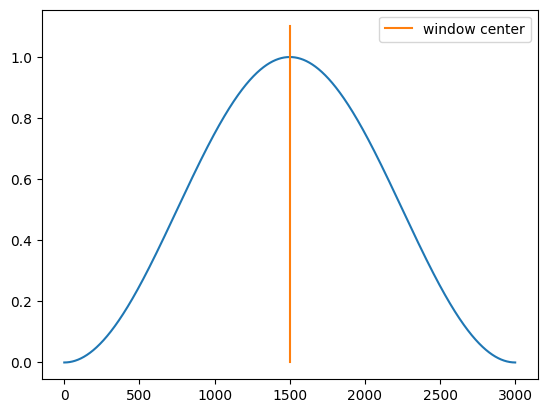

In [8]:
# 2. Weights for window transform. Before performing FFT you can scale amplitudes by a set of weights
# The weights we're gonna use are large in the middle of the window and small on the sides
dummy_window_length = 3000
dummy_weights_window = librosa.filters.get_window('hann', dummy_window_length, fftbins=True)
plt.plot(dummy_weights_window); plt.plot([1500, 1500], [0, 1.1], label='window center'); plt.legend()

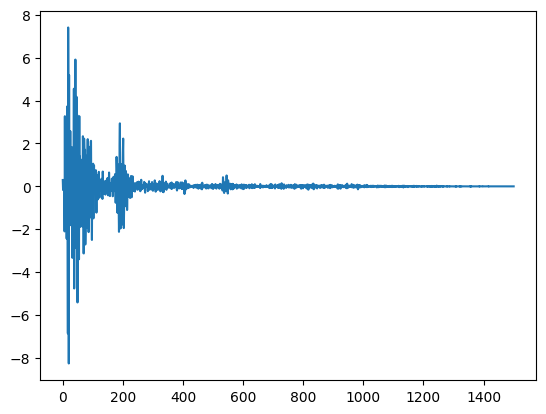

In [9]:
# 3. Fast Fourier Transform in Numpy. Note: this function can process several inputs at once (mind the axis!)
dummy_fft = np.fft.rfft(dummy_amps[:3000, None] * dummy_weights_window[:, None], axis=0)  # complex[sequence_length, num_sequences]
plt.plot(np.real(dummy_fft)[:, 0])

In [10]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # slice amplitudes into overlapping frames [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
        
    # get weights for fourier transform, float[window_length]
    fft_weights = librosa.filters.get_window('hann', window_length, fftbins=True)

    # apply fourier transfrorm to frames scaled by weights
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    
    return stft

In [22]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
    :param sample rate: num amplitudes per second
    :param n_mels: spectrogram channels
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :param f_min: minimal frequency
    :param f_max: maximal frequency
    :returns: mel-spetrogram [n_mels, duration]
    """
    # Step I: compute Short-Time Fourier Transform
    stft = get_STFT(amplitudes, window_length, hop_length)

    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Step II: convert stft to a spectrogram
    spectrogram = np.abs(stft ** 2)

    # Step III: convert spectrogram into Mel basis (multiplying by transformation matrix)
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = mel_basis @ spectrogram

    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [23]:
amplitudes, _ = librosa.core.load(wav_path)
ref = librosa.feature.melspectrogram(y=amplitudes, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes), ref, rtol=1e-3, atol=1e-3)

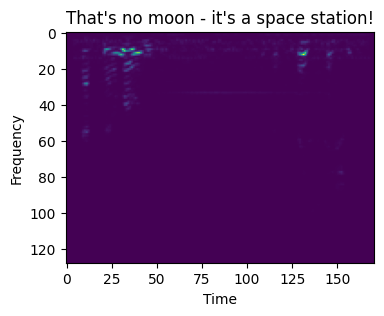

In [24]:
plt.figure(figsize=[12, 3])
plt.subplot(1, 2, 1)
plt.title("That's no moon - it's a space station!"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes))

### Задание 1.2 (2 балла) Mel-Spectrogram to Wav

Для получения аудиозаписи по спектрограмме используйте обратное преобразование из mel в sftp и алгоритм GriffinLim из librosa.

In [36]:
def mel_to_wav(mel, sr=sample_rate, n_fft=2048, power=2, 
               fmin=1, fmax=8192, window_length=2048, hop_length=512):
    stft = librosa.feature.inverse.mel_to_stft(mel, sr=sr, n_fft=n_fft, power=power, fmin=fmin, fmax=fmax)
    amplitudes = librosa.griffinlim(stft, hop_length=hop_length, win_length=window_length, n_fft=n_fft)
    return amplitudes

In [37]:
amplitudes, _ = librosa.core.load(wav_path)
mel = get_melspectrogram(amplitudes)
amplitudes_recovered = mel_to_wav(mel)
ipd.display(ipd.Audio(amplitudes_recovered, rate=sample_rate))

### Задание 2. (3 балла) Предобработка текста

Для преобразования текста в фонемы воспользуемся моделью DeepPhonemizer
https://github.com/as-ideas/DeepPhonemizer
Данная модель обучена на данных из словаря произношений Карнеги-Меллон  
https://github.com/cmusphinx/cmudict

Файл cmudict.symbols содержит список всех фонем

In [38]:
!wget https://raw.githubusercontent.com/cmusphinx/cmudict/master/cmudict.symbols -O cmudict.symbols -q
!wget https://public-asai-dl-models.s3.eu-central-1.amazonaws.com/DeepPhonemizer/en_us_cmudict_forward.pt -O en_us_cmudict_forward.pt -q

Составьте список всех фонем, состоящий из специальных символов и фонем из словаря произношений.  
В словаре phone2idx первые 12 индексов должны соответствовать специальным символам, остальные индексы должны идти в том же порядке, как в файле cmudict.symbols

In [73]:
all_symbols = {}
special_symbols = "_-!'(),.:;? "
all_symbols = {s:i for i, s in enumerate(special_symbols)}
with open('/Users/free001style/Downloads/cmudict.symbols') as f:
    for i, line in enumerate(f):
        all_symbols[line.split()[0]] = i + 12

In [97]:
import re
from nltk.tokenize import WordPunctTokenizer
from dp.phonemizer import Phonemizer
tokenizer = WordPunctTokenizer()
phonemizer = Phonemizer.from_checkpoint('en_us_cmudict_forward.pt')

def phrase_to_phones(text):
    phoneme = phonemizer(text, lang='en_us')
    regex = r'(\[\w+\])|(\s+)|(\S)'
    matches = re.findall(regex, phoneme)
    return torch.tensor([all_symbols[item.strip('[]')] for sublist in matches for item in sublist if item])

### Задание 3. (2 балла) Генерация спектраграммы

Для генерации спектраграммы по списку фонем воспользуйтесь предобученным трансформером Tacotron2 из torchaudio  
https://pytorch.org/audio/main/generated/torchaudio.pipelines.Tacotron2TTSBundle.html

In [128]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
text = "I don't like sand. It's coarse and rough and irritating and it gets everywhere."
tacotron2 = bundle.get_tacotron2()

text_idx = phrase_to_phones(text)
specgram, _, _ = tacotron2.infer(text_idx.unsqueeze(0))
spec = specgram[0].cpu().detach()

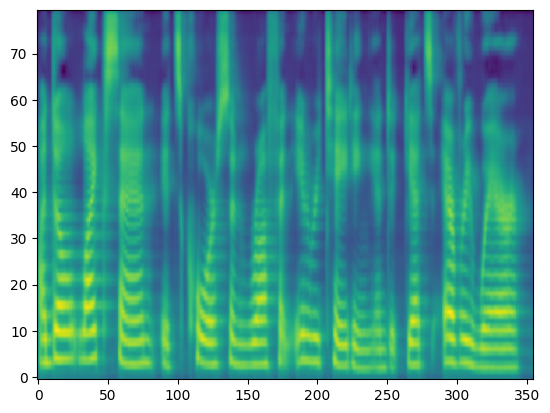

In [129]:
plt.imshow(spec, origin="lower", aspect="auto")

In [130]:
amp_synth = mel_to_wav(torch.exp(spec).numpy(), n_fft=1024, fmin=0, fmax=8000, power=1, window_length=1024, hop_length=256)
ipd.display(ipd.Audio(amp_synth, rate=sample_rate))